# Самостоятельная работа
Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

C:\Users\пользователь\AppData\Local\Temp\ipykernel_1560\4088794267.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
#Подгружаем данные, выделяем x, y, делим выборку на тренировочную и тестовую

data = pd.read_csv('data/homework.zip')
data.head()

X = data.drop(['Activity'], axis=1)
y = data['Activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [3]:
#Создаем объект класса логистическая регрессия
#использую алгоритм оптимизации saga, т.к. он работает со всеми видами регуляризации
log_reg = linear_model.LogisticRegression(max_iter = 500, solver='saga', random_state = 42)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
#f1_score на тестовом наборе: 0.778

f1_score на тестовом наборе: 0.778


c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [4]:
#Создаем объект класса случайный лес
rand_tree = ensemble.RandomForestClassifier(random_state=42)
#Обучаем модель, минимизируя logloss
rand_tree.fit(X_train, y_train)
y_test_pred = rand_tree.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
#f1_score на тестовом наборе: 0.805

f1_score на тестовом наборе: 0.805


Значения f1-меры при параметрах, установленных по умолчанию, составляют: для модели логистической регрессии - 0,778, для модели случайного леса - 0,805

## GridSearchCV

In [3]:
from sklearn.model_selection import GridSearchCV

In [22]:
#подбор на модели логистической регрессии

param_grid = {'penalty': ['l2', 'l1'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))} # уровень силы регурялизации
            
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        solver='saga',
        random_state=42, #генератор случайных чисел
        max_iter=500 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5,
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

#f1_score на тестовом наборе: 0.782
#Наилучшие значения гиперпараметров: {'C': 0.23, 'penalty': 'l1'}

CPU times: total: 2min 7s
Wall time: 1h 9min 44s
f1_score на тестовом наборе: 0.782
Наилучшие значения гиперпараметров: {'C': 0.23, 'penalty': 'l1'}


c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


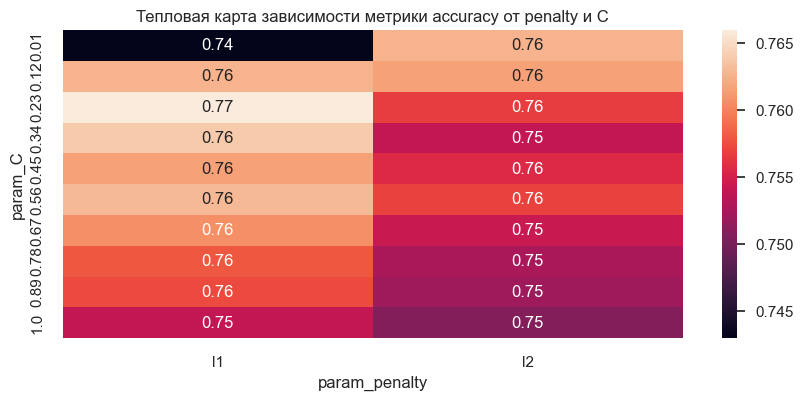

In [37]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_penalty')
sns.heatmap(visual, annot=True)
plt.title('Тепловая карта зависимости метрики accuracy от penalty и С') # подпись графика
sns.set(rc={'figure.figsize':(10, 4)}) #задаем размер графика

### Вывод:
По результатам оптимизации параметров методом gridsearch для логистической модели удалось улучшить метрику f1-score c 0.778 до 0.782. Слишком много параметров не ставил, т.к. расчёты производятся не быстро (большое количество признаков). В дальнейших вариантах оптимизации будем использовать меньший диапазон значений С для дальнейшего улучшения метрики.

In [31]:
#подбор на модели случайного леса

param_grid = {'min_samples_leaf': list(np.linspace(5, 50, 10, dtype=int)),
              'max_depth': list(np.linspace(1, 10, 10, dtype=int)),
              'criterion':['entropy','gini']
              }
            
grid_search_tree = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train, y_train) 
y_test_pred = grid_search_tree.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))
#f1_score на тестовом наборе: 0.797
#Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5}

CPU times: total: 12.8 s
Wall time: 13min 6s
f1_score на тестовом наборе: 0.797
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5}


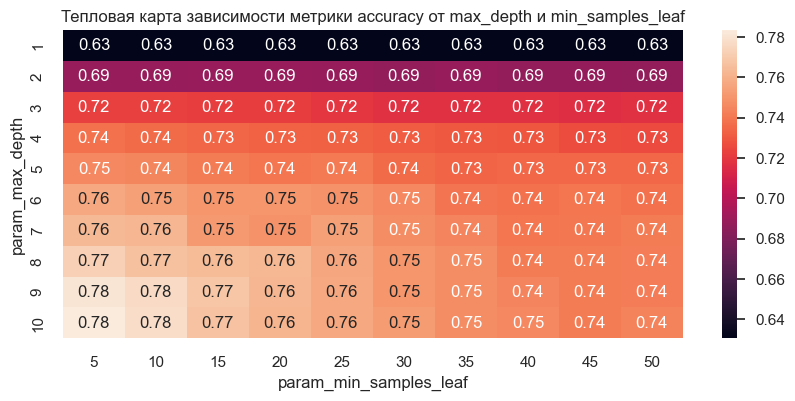

In [39]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_tree.cv_results_),
                        values='mean_test_score', index='param_max_depth',
                        columns='param_min_samples_leaf')
sns.heatmap(visual, annot=True)
plt.title('Тепловая карта зависимости метрики accuracy от max_depth и min_samples_leaf') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

### Вывод:
По результатам оптимизации параметров методом gridsearch для модели случайного леса не удалось улучшить метрику f1-score (было 0.805, стало 0.797). Слишком много параметров не ставил, т.к. расчёты производятся не быстро (большое количество признаков). В дальнейших вариантах оптимизации будем использовать немного другой диапазон значений max_depth min_samples_leaf для дальнейшего улучшения метрики.

## RandomizedSearchCV

In [4]:
from sklearn.model_selection import RandomizedSearchCV

In [58]:
#подбор на модели логистической регрессии

param_distributions = {'penalty': ['l2', 'l1'] ,
               'C': list(np.linspace(0.01, 1, 100, dtype=float))} # уровень силы регурялизации
            
rand_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(
        solver='saga',
        random_state=42, #генератор случайных чисел
        max_iter=500 #количество итераций на сходимость
    ), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 50,
    n_jobs = -1,
    random_state=42
)  
%time rand_search.fit(X_train, y_train) 
y_test_pred = rand_search.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(rand_search.best_params_))
#f1_score на тестовом наборе: 0.782
#Наилучшие значения гиперпараметров: {'penalty': 'l1', 'C': 0.23}

CPU times: total: 1min 40s
Wall time: 1h 51min 36s
f1_score на тестовом наборе: 0.782
Наилучшие значения гиперпараметров: {'penalty': 'l1', 'C': 0.23}


c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


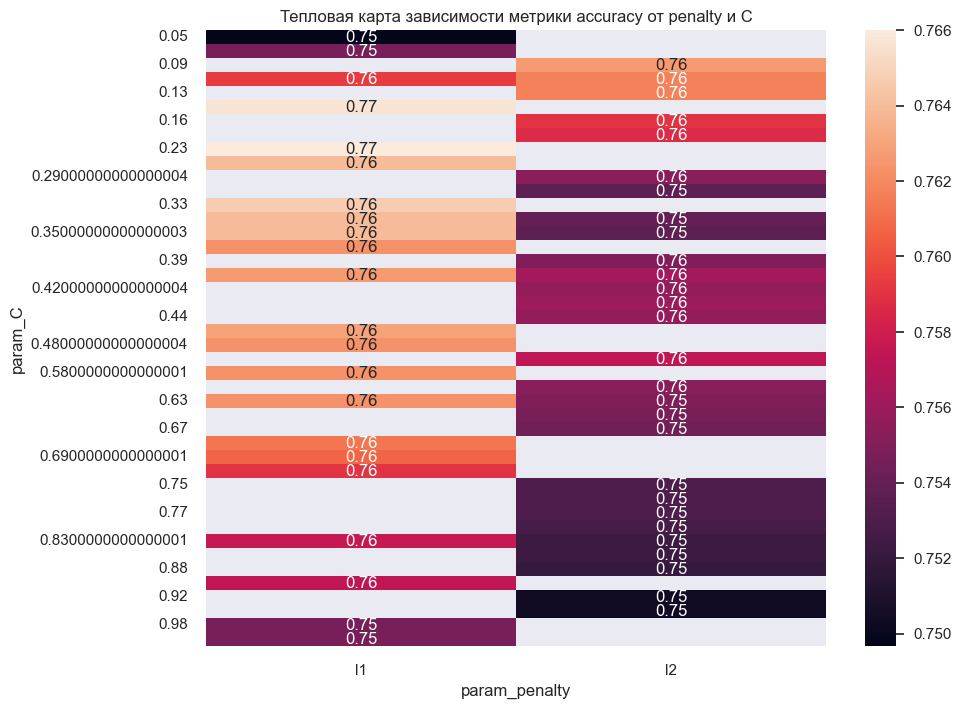

In [64]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(rand_search.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_penalty')
sns.heatmap(visual, annot=True)
plt.title('Тепловая карта зависимости метрики accuracy от penalty и С') # подпись графика
sns.set(rc={'figure.figsize':(4, 20)}) #задаем размер графика

### Вывод:
По результатам оптимизации параметров методом randomsearch для логистической значение метрики f1-score осталось без изменений -  0.782

In [56]:
#подбор на модели случайного леса
#попробуем делать только на сriterion равном gini (стоит по умолчанию)

param_distributions = {'min_samples_leaf': list(np.linspace(1, 20, 20, dtype=int)),
              'max_depth': list(np.linspace(10, 20, 20, dtype=int))
              }
            
rand_search_tree = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 50,
    n_jobs = -1,
    random_state=42
)  
%time rand_search_tree.fit(X_train, y_train) 
y_test_pred = rand_search_tree.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(rand_search_tree.best_params_))
#f1_score на тестовом наборе: 0.811
#Наилучшие значения гиперпараметров: {'min_samples_leaf': 1, 'max_depth': 17}

CPU times: total: 7.69 s
Wall time: 5min 34s
f1_score на тестовом наборе: 0.811
Наилучшие значения гиперпараметров: {'min_samples_leaf': 1, 'max_depth': 17}


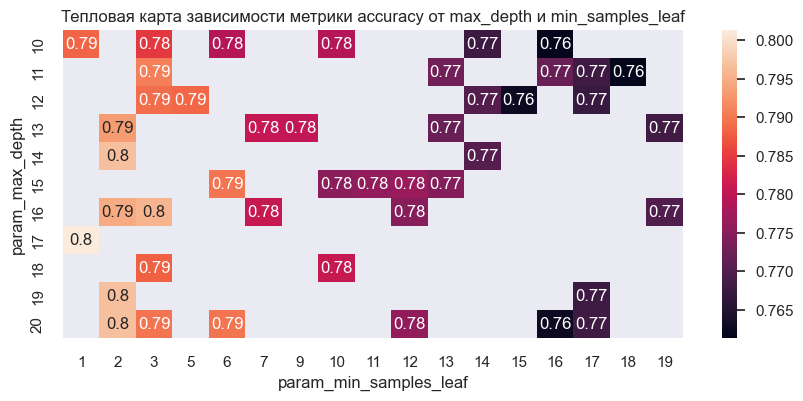

In [57]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(rand_search_tree.cv_results_),
                        values='mean_test_score', index='param_max_depth',
                        columns='param_min_samples_leaf')
sns.heatmap(visual, annot=True)
plt.title('Тепловая карта зависимости метрики accuracy от max_depth и min_samples_leaf') # подпись графика
sns.set(rc={'figure.figsize':(10, 4)}) #задаем размер графика

### Вывод:
По результатам оптимизации параметров методом randomsearch для модели случайного леса удалось улучшить метрику f1-score (было 0.805, стало 0.811).

## Hyperopt

In [5]:
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

### Hyperopt для логистической регрессии

In [37]:
# зададим пространство поиска гиперпараметров
space={'penalty': hp.choice('penalty', ['l2', 'l1']),
       'C': hp.uniform('C', 0.01, 1)
      }

In [38]:
#создаем функцию оптимизации гиперпараметров

def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=42):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
              'C': float(params['C'])
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, solver='saga', max_iter=500, random_state=42)

    # обучаем модель
    model.fit(X, y)
    
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [39]:
# начинаем подбор гиперпараметров
%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=10, # максимальное количество итераций. поставил 10 итераций, т.к. одна считается около 4 минут
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(seed=42) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

#Наилучшие значения гиперпараметров {'C': 0.16941386753130935, 'penalty': 1}

CPU times: total: 0 ns
Wall time: 0 ns
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 10%|█         | 1/10 [04:36<41:32, 276.89s/trial, best loss: -0.779494746167446]

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 30%|███       | 3/10 [13:48<30:21, 260.23s/trial, best loss: -0.7880790186755313]

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 50%|█████     | 5/10 [20:53<18:38, 223.78s/trial, best loss: -0.790775283409835] 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 60%|██████    | 6/10 [24:46<15:06, 226.72s/trial, best loss: -0.7920651360713664]

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 70%|███████   | 7/10 [30:36<13:21, 267.15s/trial, best loss: -0.7920651360713664]

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 80%|████████  | 8/10 [35:27<09:09, 274.65s/trial, best loss: -0.7920651360713664]

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 90%|█████████ | 9/10 [40:56<04:51, 291.51s/trial, best loss: -0.7920651360713664]

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 10/10 [46:08<00:00, 276.82s/trial, best loss: -0.7920651360713664]
Наилучшие значения гиперпараметров {'C': 0.16941386753130935, 'penalty': 1}


In [41]:
#cоздадим список penalty_list, т.к. в наилучших параметрах указана позиция в hp.choice('penalty', ['l2', 'l1'], вместо нахвания l1, l2
penalty_list = ['l2', 'l1']


# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=42, 
    penalty=penalty_list[best['penalty']],
    C=float(best['C']),
    solver='saga', max_iter=500
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
#f1_score на тестовом наборе: 0.776

f1_score на тестовом наборе: 0.776


c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


По результатам оптимизации параметров методом hyperopt для логистической значение метрики f1-score не удалось улучшить (стало 0.776 было 0.782). Вероятнее всего он просто не дошёл до нужного значения как было в методе randomsearch

### Hyperopt для случайного леса

In [32]:
# зададим пространство поиска гиперпараметров
space={'max_depth' : hp.quniform('max_depth', 1, 10, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 10, 20, 1)
      }

In [33]:
#создаем функцию оптимизации гиперпараметров

def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=42):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=42)

    # обучаем модель
    model.fit(X, y)
    
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [34]:
# начинаем подбор гиперпараметров
%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(seed=42) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

#Наилучшие значения гиперпараметров {'max_depth': 9.0, 'min_samples_leaf': 10.0}

CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 50/50 [09:03<00:00, 10.86s/trial, best loss: -0.7956677929156021]
Наилучшие значения гиперпараметров {'max_depth': 9.0, 'min_samples_leaf': 10.0}


In [36]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=42,
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
#f1_score на тестовом наборе: 0.779

f1_score на тестовом наборе: 0.779


### Вывод:
По результатам оптимизации параметров методом hyperopt для модели случайного леса не удалось улучшить метрику f1-score (было 0.811, стало 0.779). Вероятнее всего он просто не дошёл до нужного значения как было в методе randomsearch

## Optuna

In [6]:
import optuna

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Optuna для логистической регрессии

In [7]:

def optuna_lr(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical("penalty", ['l2', 'l1'])
  c = trial.suggest_float('C', 0.01, 1)

  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          C=c,
                                          solver='saga', max_iter=500,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [8]:
%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_lr = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз, поставил 10, т.к. считается долго
study_lr.optimize(optuna_lr, n_trials=10)

[I 2023-06-13 19:10:58,404] A new study created in memory with name: LogisticRegression


CPU times: total: 0 ns
Wall time: 0 ns


[I 2023-06-13 19:12:07,578] Trial 0 finished with value: 0.7713629321449437 and parameters: {'penalty': 'l1', 'C': 0.05925083172802704}. Best is trial 0 with value: 0.7713629321449437.
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-06-13 19:19:09,477] Trial 1 finished with value: 0.7782997060874133 and parameters: {'penalty': 'l1', 'C': 0.9781608052164892}. Best is trial 1 with value: 0.7782997060874133.
[I 2023-06-13 19:21:13,933] Trial 2 finished with value: 0.780300970325843 and parameters: {'penalty': 'l2', 'C': 0.21865217038022508}. Best is trial 2 with value: 0.780300970325843.
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-06-13 19:25:

In [9]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_lr.best_params))
print("f1_score на обучающем наборе: {:.3f}".format(study_lr.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l1', 'C': 0.14892450566066537}
f1_score на обучающем наборе: 0.790


In [12]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study_lr.best_params, solver='saga', max_iter=500, random_state=42)
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

#f1_score на тестовом наборе: 0.770

f1_score на тестовом наборе: 0.770


In [11]:
#посмотрим на динамику оптимизации признака
optuna.visualization.plot_optimization_history(study_lr, target_name="f1_score")

### Вывод:
По результатам оптимизации параметров методом optuna для модели логистической регрессии не удалось улучшить метрику f1-score (было 0.782, стало 0.770). Вероятнее всего он просто не дошёл до нужного значения как было в методе randomsearch

### Optuna для случайного леса

In [5]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [6]:
%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf.optimize(optuna_rf, n_trials=50)

[I 2023-06-12 20:49:47,186] A new study created in memory with name: RandomForestClassifier


CPU times: total: 0 ns
Wall time: 0 ns


[I 2023-06-12 20:50:07,368] Trial 0 finished with value: 0.8062984209303359 and parameters: {'max_depth': 27, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8062984209303359.
[I 2023-06-12 20:50:22,059] Trial 1 finished with value: 0.8132756077845098 and parameters: {'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8132756077845098.
[I 2023-06-12 20:50:40,894] Trial 2 finished with value: 0.8094663563260959 and parameters: {'max_depth': 29, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8132756077845098.
[I 2023-06-12 20:51:07,535] Trial 3 finished with value: 0.8025748053971791 and parameters: {'max_depth': 22, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8132756077845098.
[I 2023-06-12 20:51:31,327] Trial 4 finished with value: 0.8092868574212225 and parameters: {'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8132756077845098.
[I 2023-06-12 20:51:54,071] Trial 5 finished with value: 0.8079441578493467 and parameters

In [7]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_rf.best_params))
print("f1_score на обучающем наборе: {:.3f}".format(study_rf.best_value))

#Наилучшие значения гиперпараметров {'max_depth': 14, 'min_samples_leaf': 1}
#f1_score на обучающем наборе: 0.820

Наилучшие значения гиперпараметров {'max_depth': 14, 'min_samples_leaf': 1}
f1_score на обучающем наборе: 0.820


In [8]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study_rf.best_params,random_state=42)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

#f1_score на тестовом наборе: 0.807

f1_score на тестовом наборе: 0.807


In [9]:
#посмотрим на динамику оптимизации признака
optuna.visualization.plot_optimization_history(study_rf, target_name="f1_score")

### Вывод:
По результатам оптимизации параметров методом optuna для модели случайного леса не удалось улучшить метрику f1-score (было 0.811, стало 0.807). Вероятнее всего он просто не дошёл до нужного значения как было в методе randomsearch